# Speech Emotion Recognition using MLPClassifier

#### Summary
This project presents a deep learning classifier able to predict the emotions of a human speaker encoded in an audio file. The classifier is trained using 2 different datasets, RAVDESS and TESS on 8 classes (neutral, calm, happy, sad, angry, fearful, disgust and surprised).

#### Feature set information

For this task, the dataset is built using 5252 samples from:

- the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) dataset
- the Toronto emotional speech set (TESS) dataset

#### The samples include:

- 1440 speech files and 1012 Song files from RAVDESS. This dataset includes recordings of 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes calm, happy, sad, angry, fearful, surprise, and disgust expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each file was rated 10 times on emotional validity, intensity, and genuineness. Ratings were provided by 247 individuals who were characteristic of untrained adult research participants from North America. A further set of 72 participants provided test-retest data. High levels of emotional validity, interrater reliability, and test-retest intrarater reliability were reported. Validation data is open-access, and can be downloaded along with our paper from PLoS ONE.

- 2800 files from TESS. A set of 200 target words were spoken in the carrier phrase "Say the word _____' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 stimuli in total. Two actresses were recruited from the Toronto area. Both actresses speak English as their first language, are university educated, and have musical training. Audiometric testing indicated that both actresses have thresholds within the normal range.

The classes the model wants to predict are the following: (0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised).

#### File naming convention

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

***Filename identifiers***

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
- Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

***Filename example: 02-01-06-01-02-01-12.wav***

- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement “dogs” (02)
- 1st Repetition (01)
- 12th Actor (12)
- Female, as the actor ID number is even.

In [30]:
#Install all the Reqiuired Libraries and Packages 
import os
import glob
import random
import shutil
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile 
from scipy.fftpack import fft
from python_speech_features import mfcc , logfbank
import librosa as lr
import pickle
import soundfile
import speech_recognition as sr
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
get_ipython().magic('matplotlib inline')

In [31]:
# setting base directory for the project
CURR_DIR = os.getcwd()
# print(CURR_DIR)
# BASE_DIR = f"{CURR_DIR}/drive/MyDrive/project-final"
BASE_DIR = CURR_DIR
# print(f"{BASE_DIR}")

DATASET_PATH = os.path.join(BASE_DIR,'datasets')
# print(DATASET_PATH)
TRAINING_FILES_PATH = os.path.join(BASE_DIR,'training_dataset')
# print(TRAINING_FILES_PATH)

In [32]:
"""
We are filling folders Actor_25 if YAF and Actor_26 if OAF.
The files will be copied and renamed and not simply moved (to avoid messing up
things during the development of the pipeline.
Actor_25 and Actor_26 folders must be created before launching this script.
Example filename: 03-01-07-02-02-01-01.wav
"""

path = os.path.join(DATASET_PATH,'TESS_Toronto_emotional_speech_dataset')
counter = 0

label_conversion = {'01': 'neutral',
                    '03': 'happy',
                    '04': 'sad',
                    '05': 'angry',
                    '06': 'fear',
                    '07': 'disgust',
                    '08': 'ps'}
'''
for subdir, dirs, files in os.walk(path):
    for filename in files:
        if filename.startswith('OAF'):
            destination_path = os.path.join(TRAINING_FILES_PATH,'Actor_26')
            # print(destination_path)
            old_file_path = os.path.join(os.path.abspath(subdir), filename)
            # print(old_file_path)

            # Separate base from extension
            base, extension = os.path.splitext(filename)

            for key, value in label_conversion.items():
                if base.endswith(value):
                    random_list = random.sample(range(10, 99), 7)
                    file_name = '-'.join([str(i) for i in random_list])
                    file_name_with_correct_emotion = file_name[:6] + key + file_name[8:] + extension
                    # new_file_path = destination_path + file_name_with_correct_emotion
                    new_file_path = os.path.join(destination_path ,file_name_with_correct_emotion)
                    # print(new_file_path)
                    shutil.copy(old_file_path, new_file_path)

        else:
            destination_path = os.path.join(TRAINING_FILES_PATH,'Actor_25')
            old_file_path = os.path.join(os.path.abspath(subdir), filename)

            # Separate base from extension
            base, extension = os.path.splitext(filename)

            for key, value in label_conversion.items():
                if base.endswith(value):
                    random_list = random.sample(range(10, 99), 7)
                    file_name = '-'.join([str(i) for i in random_list])
                    file_name_with_correct_emotion = (file_name[:6] + key + file_name[8:] + extension).strip()
                    new_file_path = os.path.join(destination_path ,file_name_with_correct_emotion)
                    shutil.copy(old_file_path, new_file_path)
'''
print("********** Done ********************")

********** Done ********************


In [33]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE 
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [5]:
#The clean Audio Files are redirected to Clean Audio Folder Directory 

for file in tqdm(glob.glob(f'{TRAINING_FILES_PATH}/**/*.wav')):
    file_name = os.path.basename(file)
    signal , rate = lr.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= f'{BASE_DIR}/clean_speech/'+str(file_name), rate=rate,data=signal[mask])

100%|████████████████████████████████████████████████████████████████████| 5251/5251 [17:35<00:00,  4.97it/s]


In [34]:
#Emotions in the RAVDESS dataset to be classified Audio Files based on . 
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

In [7]:
# Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(lr.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(lr.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(lr.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(lr.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        return result


In [35]:
#Load the data and extract features for each sound file
def load_data(test_size=0.33):
    x,y=[],[]
    answer = 0
    for file in glob.glob(f"{BASE_DIR}/clean_speech/*.wav"):
        file_name=os.path.basename(file)
        # print(file_name)
        emotion=emotions[file_name.split("-")[2]]
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])

    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)
print('Done')

Done


In [36]:
x_train,x_test,y_train,y_test=load_data(test_size=0.25)
print(np.shape(x_train),np.shape(x_test), np.shape(y_train),np.shape(y_test))
y_test_map = np.array(y_test).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_train).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))
# print(*test_filename,sep="\n")

(3938, 180) (1313, 180) (3938, 2) (1313, 2)
(3938,) (1313,)


In [37]:
#Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

(3938, 1313)
Features extracted: 180


In [38]:
#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(400, 350, 300), learning_rate='adaptive', max_iter=2000,early_stopping=False)

In [39]:
#Train the model
model = model.fit(x_train,y_train)

In [13]:
# Save the Modle to file in the current working directory
#For any new testing data other than the data in dataset
model_filename = f"{BASE_DIR}/model/SER_Model.pkl"  

with open(model_filename, 'wb') as file:  
    pickle.dump(model, file)


In [14]:
# Load the Model back from file 
with open(model_filename, 'rb') as file:
    SER_Model = pickle.load(file)


In [40]:
#predicting :
# x_test=train_test_split(test_size=0.25)
y_pred=SER_Model.predict(x_test)

In [55]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.95      0.82      0.88       188
        calm       0.84      0.84      0.84       104
     disgust       0.78      0.93      0.84       149
     fearful       0.72      0.88      0.79       185
       happy       0.80      0.83      0.81       173
     neutral       0.96      0.86      0.91       165
         sad       0.90      0.76      0.82       201
   surprised       0.85      0.86      0.86       148

    accuracy                           0.84      1313
   macro avg       0.85      0.84      0.84      1313
weighted avg       0.85      0.84      0.84      1313



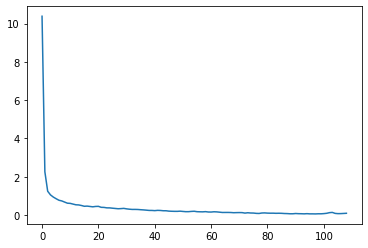

In [41]:
# plotting loss curve
plt.plot(model.loss_curve_)
plt.title = "Loss Curve"
plt.xlabel = 'Iterations'
plt.ylabel = 'Cost'
plt.show()

In [42]:
# Calculate the accuracy of our model. 
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred) 
# Print the accuracy 
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 86.14%


In [43]:
y_pred1 = pd.DataFrame(y_pred, columns=['predictions'])
y_pred1['file_names'] = test_filename
print(y_pred1)
y_pred1.to_csv(f'{BASE_DIR}/prediction.csv')

     predictions                file_names
0            sad  57-46-04-37-87-52-73.wav
1      surprised  03-01-08-01-02-02-15.wav
2        disgust  66-89-07-78-34-70-19.wav
3      surprised  64-60-08-38-58-61-45.wav
4        neutral  18-78-01-65-98-63-41.wav
...          ...                       ...
1308       angry  03-01-05-02-01-01-24.wav
1309         sad  15-87-04-88-47-39-12.wav
1310         sad  38-94-04-98-85-40-57.wav
1311       happy  03-01-03-01-02-02-21.wav
1312         sad  03-02-04-02-01-01-16.wav

[1313 rows x 2 columns]


epoch:  0


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  1


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  2


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  3


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  4


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  5


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  6


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  7


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  8


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  9


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  10


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  11


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  12


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  13


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  14


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  15


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  16


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  17


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  18


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  19


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  20


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  21


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  22


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  23


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


epoch:  24


D:\project-main\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:611: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


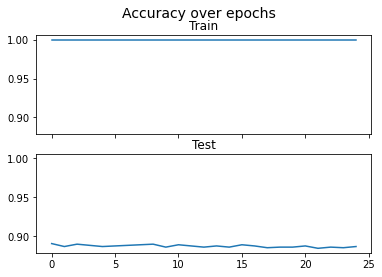

In [65]:
N_TRAIN_SAMPLES = x_train.shape[0]

N_EPOCHS = 25
N_BATCH = 128
N_CLASSES = np.unique(y_train)

scores_train = []
scores_test = []

# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    print('epoch: ', epoch)
    # SHUFFLING
    random_perm = np.random.permutation(x_train.shape[0])
    mini_batch_index = 0
    while True:
        # MINI-BATCH
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        model.partial_fit(x_train[indices], y_train[indices], classes=N_CLASSES)
        mini_batch_index += N_BATCH

        if mini_batch_index >= N_TRAIN_SAMPLES:
            break

    # SCORE TRAIN
    scores_train.append(model.score(x_train, y_train))

    # SCORE TEST
    scores_test.append(model.score(x_test, y_test))

    epoch += 1

""" Plot """
fig, ax = plt.subplots(2, sharex=True, sharey=True)
ax[0].plot(scores_train)
ax[0].set_title('Train')
ax[1].plot(scores_test)
ax[1].set_title('Test')
fig.suptitle("Accuracy over epochs", fontsize=14)
plt.show()

### Running examples

In [44]:
# running examples files store in examples directory
# to test new files upload it in examples directory
for file in glob.glob(f'{BASE_DIR}/examples/*.*'):
    data, sampling_rate = lr.load(file)
    ## Appying extract_feature function on random file and then loading model to predict the result 
    ans =[]
    new_feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
    ans.append(new_feature)
    ans = np.array(ans)
    predicted = SER_Model.predict(ans)
    print(f"File : {os.path.basename(file)}  => Emotion : {predicted[0]}")

File : output10.wav  => Emotion : angry
File : YAF_book_happy.wav  => Emotion : angry


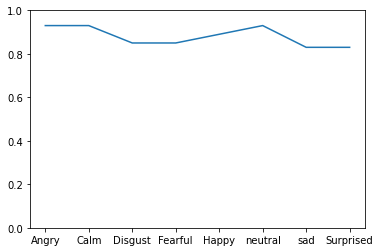

In [45]:
import matplotlib.pyplot as plt
emotion = ['Angry',
'Calm',
'Disgust',
'Fearful',
'Happy',
'neutral',
'sad',
'Surprised']
accuracy = [0.93,
            0.93,
            0.85,
            0.85,
            0.89,
            0.93,
            0.83,
            0.83]
plt.plot(emotion,accuracy)
plt.title = "Sports Watch Data"
plt.xlabel = 'Month'
plt.ylabel = "Calorie Burnage"
plt.ylim(ymin=0)
plt.ylim(ymax=1)
plt.show()